# SIIM-FISABIO-RSNA COVID-19 Detection using EfficientDet (Inference)
  
## Performance Comparison of Similar Models

<figure>
<img src="https://blog.roboflow.com/content/images/2020/06/yolov5-performance.png" style="width:700px">
</figure>

Check out the [EfficientDet Research Paper ](https://arxiv.org/pdf/1911.09070.pdf)  


## EfficientDet Structure
![image](https://aihub-storage.s3.ap-northeast-2.amazonaws.com/file/efficientdet.png)

## Install Dependencies

In [1]:
import os
!cp -r '/kaggle/input/cocoapi' '/kaggle/'
os.chdir('/kaggle/cocoapi/cocoapi/PythonAPI')
!make
!make install
!python setup.py install

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/opt/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /kaggle/cocoapi/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
gcc -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/conda/lib/python3.7/site-packages/numpy/core/include -I../common -I/opt/conda/include/python3.7m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.7/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: t

In [2]:
!conda install '/kaggle/input/pydicom-conda-helper/libjpeg-turbo-2.1.0-h7f98852_0.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/libgcc-ng-9.3.0-h2828fa1_19.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/gdcm-2.8.9-py37h500ead1_1.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/conda-4.10.1-py37h89c1867_0.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/certifi-2020.12.5-py37h89c1867_1.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/pydicom-conda-helper/openssl-1.1.1k-h7f98852_0.tar.bz2' -c conda-forge -y
!conda install '/kaggle/input/notebook6765ef7aa0/webcolors-1.11.1-pyhd8ed1ab_0.tar.bz2' -c conda-forge -y


######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ | done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ | / - \ | / - \ | / - \ | / - \ | / done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done

#####################

## Move Directory

In [3]:
!cp -r /kaggle/input/efficientdet-training-better-than-yolov5/Yet-Another-EfficientDet-Pytorch /kaggle/

In [4]:
os.chdir('/kaggle/Yet-Another-EfficientDet-Pytorch/')

## Preprocessing Test Image

In [5]:
import pandas as pd
from glob import glob

if pd.read_csv('/kaggle/input/siim-covid19-detection/sample_submission.csv').shape[0] == 2477:
    fast_sub = True
    
    INPUT_PATH = 'datasets/siim/tmp/'
    
    # move just 5 folders
    sample = os.listdir('/kaggle/input/siim-covid19-detection/test/')[:5]
    os.makedirs(INPUT_PATH, exist_ok=True)
    for i in sample:
        !cp -r '/kaggle/input/siim-covid19-detection/test/'{i} {INPUT_PATH}
    
    tmp = []
    for path in glob(INPUT_PATH + '*'):
        study_name = path.split('/')[-1][:-4]
        tmp.append([f'{study_name}_study', 'negative 1 0 0 1 1'])

    for path in glob(INPUT_PATH + '*/*/*'):
        image_name = path.split('/')[-1][:-4]
        tmp.append([f'{image_name}_image', 'none 1 0 0 1 1'])

    submission = pd.DataFrame(tmp, columns=['id', 'PredictionString'])

else:
    fast_sub = False
    INPUT_PATH = '/kaggle/input/siim-covid19-detection/test/'
    submission = pd.read_csv('/kaggle/input/siim-covid19-detection/sample_submission.csv')

In [6]:
import os
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import torch

def read_xray(path, voi_lut=False, fix_monochrome=True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array

    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data

    
def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)

    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)

    return im

In [7]:
from glob import glob

save_dir = "datasets/siim/test"
!rm -rf {save_dir}
os.makedirs(save_dir, exist_ok=True)

image_size_dict = {}
for path in tqdm(glob(INPUT_PATH + '*/*/*')):
    # set keep_ratio=True to have original aspect ratio
    xray = read_xray(path)
    image_size_dict[path.split('/')[-1][:-4]] = xray.shape
    im = resize(xray, size=256)
    im.save(os.path.join(save_dir, path.split('/')[-1][:-3]+'jpg'))

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
submission[submission.id.str.contains('image')]

,id,PredictionString
5,9850b5470fd6_image,none 1 0 0 1 1
6,7230234e120a_image,none 1 0 0 1 1
7,dfc5c09a50bc_image,none 1 0 0 1 1
8,a29c5a68b07b_image,none 1 0 0 1 1
9,8d6dea06a032_image,none 1 0 0 1 1


## Evaluation

In [9]:
weight_file = !ls logs/siim/
! python coco_eval.py -c 0 -p siim -w "logs/siim/{weight_file[-2]}"

running coco-style evaluation on project siim, weights logs/siim/efficientdet-d0_9_3160.pth...
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
100%|███████████████████████████████████████| 1267/1267 [01:41<00:00, 12.49it/s]
Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
BBox
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.58s).
Accumulating evaluation results...
DONE (t=0.63s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.051
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

## Test

In [10]:
name2color = {
    'Negative' : [0, 0, 0], # Typical Appearance
    'Typical': [66,9,255], # Typical Appearance
    'Indeterminate': [255,186,8], # Indeterminate Appearance
    'Atypical': [247,37,69], # Atypical Appearance
}

"""
Simple Inference Script of EfficientDet-Pytorch
"""
import time
import torch
from torch.backends import cudnn
from matplotlib import colors

from backbone import EfficientDetBackbone
import cv2
import numpy as np
import matplotlib.pyplot as plt

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess, STANDARD_COLORS, standard_to_bgr, get_index_label, plot_one_box


## Model Upload

In [11]:
compound_coef = 0
force_input_size = None  # set None to use default size
img_path = 'datasets/siim/test/'
img_list = glob(img_path + '*')

# replace this part with your project's anchor config
anchor_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]
anchor_scales = [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = ['Typical', 'Indeterminate', 'Atypical']


color_list = standard_to_bgr(STANDARD_COLORS)
# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                             ratios=anchor_ratios, scales=anchor_scales)
model.load_state_dict(torch.load('logs/siim/efficientdet-d0_39_12600.pth', map_location='cpu'))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

## Display

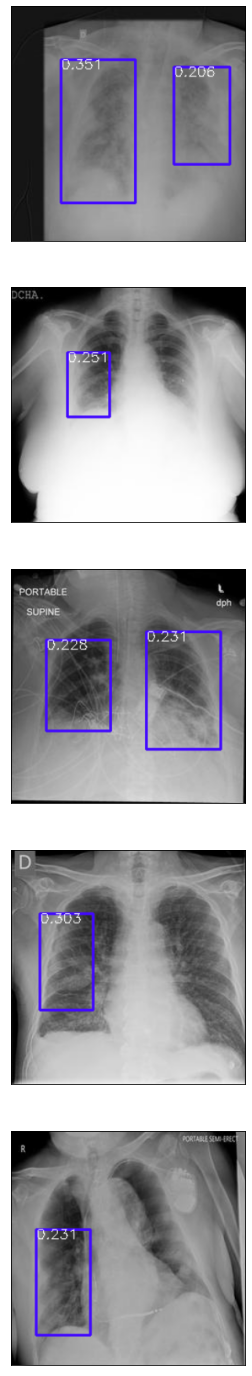

In [12]:
def display(preds, imgs):
    for i in range(len(imgs)):
        if len(preds[i]['rois']) == 0:
            continue

        imgs[i] = imgs[i].copy()

        for j in range(len(preds[i]['rois'])):
            x1, y1, x2, y2 = preds[i]['rois'][j].astype(np.int)
            obj = obj_list[preds[i]['class_ids'][j]]
            cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), name2color[obj], 2)
            score = float(out[i]['scores'][j])

            cv2.putText(ori_imgs[i], '{:.3f}'.format(score),
                        (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (255,255,255), 1)
        return imgs[i]
    
imgs = []
for k, img_path in enumerate(img_list[:5]):
    ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

    if use_cuda:
        x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
    else:
        x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

    x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

    with torch.no_grad():
        features, regression, classification, anchors = model(x)

        regressBoxes = BBoxTransform()
        clipBoxes = ClipBoxes()

        out = postprocess(x,
                          anchors, regression, classification,
                          regressBoxes, clipBoxes,
                          threshold, iou_threshold)

    out = invert_affine(framed_metas, out)
    imgs.append(display(out, ori_imgs))
    
fig = plt.figure(figsize=(5, len(imgs)*5))
for i, img in enumerate(imgs[:30]):
    img = cv2.resize(img, (300,300))
    ax = fig.add_subplot(len(imgs), 1, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(img)

blue box : typical  
yellow box : indeterminate  
red box : atypical  

![image](https://aihub-storage.s3.ap-northeast-2.amazonaws.com/file/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA_2021-07-18_%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE_10.53.32.png)

## Inference

In [13]:
pcs_imgs = []
for k, img_path in enumerate(img_list):
    ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

    if use_cuda:
        x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
    else:
        x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

    x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)
    
    pcs_imgs.append(x)
    with torch.no_grad():
        features, regression, classification, anchors = model(x)

        regressBoxes = BBoxTransform()
        clipBoxes = ClipBoxes()

        out = postprocess(x,
                          anchors, regression, classification,
                          regressBoxes, clipBoxes,
                          threshold, iou_threshold)

    out = invert_affine(framed_metas, out)
    imgs.append(display(out, ori_imgs))

batch size is 32.

In [14]:
outs = []
batch = 32
with torch.no_grad():
    for i in range(len(pcs_imgs)//batch + 1):
        features, regression, classification, anchors = model(torch.cat(pcs_imgs[batch*i:batch*(i+1)]))

        regressBoxes = BBoxTransform()
        clipBoxes = ClipBoxes()

        out = postprocess(torch.cat(pcs_imgs[batch*i:batch*(i+1)]),
                          anchors, regression, classification,
                          regressBoxes, clipBoxes,
                          threshold, iou_threshold)
        outs += out

In [15]:
outs[0]

{'rois': array([[108.11608, 116.73778, 270.56287, 428.57104],
        [355.1469 , 133.98311, 476.58972, 344.52795]], dtype=float32),
 'class_ids': array([0, 0]),
 'scores': array([0.35103002, 0.2056604 ], dtype=float32)}

Result looks like this. 
  
**rois** : box position  
**class_ids** : 0 => typical, 1 => indeterminate, 2=> atypical  
**scores** : confidence  